#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [1]:
!pip install learn2learn
!pip install torchmeta

import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import learn2learn as l2l
import torch.utils
from torchmeta.modules import (MetaModule, MetaSequential, MetaConv2d,
                               MetaBatchNorm2d, MetaLinear)
from torchmeta.utils.gradient_based import gradient_update_parameters

colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Project/data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## RESISC45

---

In [2]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate = 0.0006
MAML_learning_rate = 0.0006
CNN_learning_rate = 0.0006
MAML2_learning_rate1=.00045
MAML2_learning_rate2=0.0001/8
n_epochs = 150
print_stride = 10
Freeze=False
First_Train = True
no_load = True
bce_loss = nn.BCELoss()
No_Overlap = True

In [3]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

def make_dataset(x, y):
    x = torch.tensor(x).permute(0,3,1,2)
    y = torch.tensor(y)
    dset = CustomTensorDataset(x, y)
    return dset

In [4]:
def get_data(dir, mtype,nwaykshot=False,No_Overlap=False):
    if mtype=='MAML': batch_n = batch_size*2
    else: batch_n = batch_size

    data = np.load(dir+'RESISC45_images_96.npy')
    labels = np.load(dir+'RESISC45_classes.npy')
    classes = np.load(dir+'RESISC45_class_names.npy')
    if No_Overlap:
        scenes = ['airport',
                  'basketball_court',
                  'bridge',
                  'church',
                  'circular_farmland',
                  'cloud',
                  'commercial_area',
                  'desert',
                  'ground_track_field',
                  'industrial_area',
                  'island',
                  'lake',
                  'meadow',
                  'mountain',
                  'palace',
                  'railway',
                  'railway_station',
                  'rectangular_farmland',
                  'roundabout',
                  'sea_ice',
                  'ship',
                  'snowberg',
                  'stadium',
                  'terrace',
                  'thermal_power_station',
                  'wetland']
        mask = np.isin(classes, scenes)
        classes = classes[mask]
        filterset = np.arange(len(mask))[mask]
        mask = np.isin(labels, filterset)
        labels = labels[mask]
        data = data[mask]
        setlabs = list(set(labels))
        labels = np.array([setlabs.index(x) for x in labels])
    #img_size = train_data.shape[2]
    c_dim = classes.shape[0]

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size, stratify = labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = val_size)
    trainset = make_dataset(xtrain,ytrain)
    train_loader = DataLoader(trainset, batch_size=int(batch_n), shuffle=True)

    valset = make_dataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_n, drop_last = True, shuffle=True)

    testset = make_dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_n, drop_last = True, shuffle=True)
    if nwaykshot==True:
        return trainset, val_loader, test_loader, c_dim, classes, ytrain
    return train_loader, val_loader, test_loader, c_dim, classes
def tasksplit_uneven(x,y,Params):
    ## split inner and outer loop by incidies
    skip =2 
    idx = idx = torch.arange(start =1, end=x.shape[0]+1).bool()
    idx[::skip] = False
    x_inner = x[idx]
    y_inner = y[idx]
    x_outer = x[~idx]
    y_outer = y[~idx]
    return x_inner, x_outer, y_inner,y_outer

In [5]:

import learn2learn as l2l
def taskStructure(dataset,Params,trainlabels): ## pass train into here
    print(trainlabels)
    labels= {}
    for i in range(Params['num_classes']):
        labels[i] = [j for j, x in enumerate(trainlabels) if x == i]
    metaDataset = l2l.data.MetaDataset(dataset,labels_to_indices=labels)
    
    transforms = [
    ## need kshots*2 for inner and outer loop split accross each task
        l2l.data.transforms.FusedNWaysKShots(metaDataset,n=Params['nways'],k=Params['kshots']*2,replacement=False),
        l2l.data.transforms.LoadData(metaDataset),
        l2l.data.transforms.ConsecutiveLabels(metaDataset)
    ]
    taskset = l2l.data.TaskDataset(metaDataset,
                                   transforms,
                                   num_tasks=len(dataset)/(Params['nways']*Params['kshots']*2))
        
    return taskset


In [6]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (batch_size, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.fce = nn.Linear(1024, 26)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        x = x/127.5 - 1.0
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z

    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


def get_model(mtype, lr=0.0006, train=True,load=False):
    model = Conv_Pred().to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

def one_hot_embedding(labels, dims):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = dims)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [7]:
## for general MAML
class ConvolutionalNeuralNetwork(MetaModule):
    def __init__(self,Params,in_channels=3,out_features=45,hidden_size=2):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = Params['in_channels']
        self.out_features = Params['num_classes']
        self.hidden_size = Params['hidden_size']

        self.features  = MetaSequential(
            MetaConv2d(in_channels,hidden_size**5,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            MetaConv2d(hidden_size**5,hidden_size**6,kernel_size=4,stride=2,padding=1,bias=False),
            MetaBatchNorm2d(hidden_size**6),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 6, hidden_size ** 7, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size**7),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 7, hidden_size ** 8, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 8),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 8, hidden_size ** 9, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 9),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 9, hidden_size ** 10, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 10),
            nn.ReLU(),
        )
        self.fce = MetaLinear(self.hidden_size**10, 26)



    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])
    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.fce(features, params=self.get_subdict(params, 'classifier'))
        return logits
        
    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])

def get_meta_model(Params,train=True,load=False):
    model = ConvolutionalNeuralNetwork(Params).to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model

In [8]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(96,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [9]:
def train(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype, augs=True, print_stride1=print_stride):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128

    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    for epoch in range(1, n_epochs+1):

        losses = []

        for X, y in train_loader:

            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':

                X1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                X2 = X[int(X.shape[0]/2):].float().clone().to(device)
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)

                task_batch1 = applyAugs(X1, int(i%tasks)).to(device)
                task_batch2 = applyAugs(X2, int(i%tasks)).to(device)
                i += 1

                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch1)
                pred_loss = bce_loss(yhat, y1)
                pred_loss.backward()

                model1_optimizer.step()

                losses += [pred_loss.item()]
                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch2)
                pred_loss = bce_loss(yhat, y2)
                pred_loss.backward()

                for m1, m2 in zip(model.named_parameters(), model1.named_parameters()):
                    m1[1].grad = m2[1].grad.clone()
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)

                if augs: X = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(X)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()

            model_optimizer.step()

            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:
            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]
                    
                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

                print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
                print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
                
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
          
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker



In [10]:
## MORE MMAML FEATURES N TASK BATCH SIZE AND REGULARIZIAING INNER LOOP TO MIDIGATE FIRST ORDER APROXIMATION
def train2(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype,print_stride1 = print_stride, trainset= None, nwaykshot=False , train_labels = None,Params=None):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128
    alpha=.008
    print(mtype)
    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0)
    n=32
    for epoch in range(1, n_epochs+1):
        if nwaykshot==True:
                train_loader = taskStructure(trainset,Params,train_labels)
        losses = []
        j=0
        TasksInOuterSum = n
        pred_loss=torch.tensor(0.)
        model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
        for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o

        for X, y in train_loader:
            i = torch.randint(high=127, size=(1, 1)).item()
            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML2':
                ## I added support for having the outer loop contain multiple tasks, it has been cited by Cheasea finn, 
                #the creator of MAML for fast adaption this is where the model does the most work the outerloop, so we will back load it with 256 images instead of 32
                # This will be done by doing the update of the j variable is a multiple of n, for instance if n is = 8 in the code see line  so we get 8*32=256 images all form same tasks as the inner loop per outer update
                X = applyAugs(X.float().clone().to(device), int(i))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper

                ## data prep for inner and outer loop
                task_batch1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                task_batch2 = X[int(X.shape[0]/2):].float().clone().to(device) ## now each batch
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)
                ## start inner loop
                ## with first order we update the models weights after each inner loop to prevent the hessian update
                ## We wish to find a good intiiallzation point for all tasks so this inner loop should either have a small learning rate or a regularizer
                ## I will use a regulizer to enforce some closeness to the initial point, note te more images we have in the outer loop update step the further we will be 
                ## from the initialization point, ideally maml without any apoximation calls aims to acheive this
                
                ## get logits with the loss for the inner loop
                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1,weight_decay =alpha)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                inner_logit = model1(task_batch1)
                inner_loss = bce_loss(inner_logit, y1)
                inner_loss.backward() ## innner backwards
                model1_optimizer.step() ## inner loss update not on orginal model
                losses += [inner_loss.item()]

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                ## now with the updated_params dict we will take outerloop without updating the params on the inner loop
                outer_logit =  model1(task_batch2) ## get outer logits  with inner loss's params
                outer_loss = bce_loss(outer_logit,y2)
                outer_loss.backward()

                for m1, m2 in zip(model3.named_parameters(), model1.named_parameters()): ## add weights to container
                    m1[1].grad = m1[1].grad + m2[1].grad.clone()

                ## we will now update the model after seeing our n tasks with j%n
                ## time to clone
                if j%TasksInOuterSum ==0:
                    for m1, m2 in zip(model.named_parameters(), model3.named_parameters()):
                        m1[1].grad = m2[1].grad.clone()
                    ## do the update here
                    model_optimizer.step()
                    for param in model.parameters(): param.grad = None
                    for param in model1.parameters(): param.grad = None
                    for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o
                losses += [outer_loss.item()]
    
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)
                task_batch = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(task_batch)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()
                ## moved these inside, We only wish to do it for the cnn
                model_optimizer.step()
            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:

            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]

                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker




In [11]:
## general mamal train
from torchmeta.utils.gradient_based import gradient_update_parameters
import torch.nn.functional as F


def trainMAML(mtype,model, train_tasks, Params, val_loader, print_stride1, nwaykshot=False, trainset=False,train_labels=False):  ## go through data set


    epoch_tracker, loss_tracker, val_accs, val_topks,trainacc = [], [], [], [],[]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    model.to(device)

    if mtype!='MAMLnk':
        return False

      # keeping track of tasks seen make sure to see entrie dataset

    for epoch in range(1, Params['epoch']+1):

        tracc, trlosses= looptrain(Params,model,train_tasks,nwaykshot,trainset=trainset,train_labels= train_labels)

        trainacc.append(tracc)
        loss_tracker.append(trlosses)
        with torch.no_grad():
            accs, actk = [], []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                yhat = model(x)
                
                yhat_max = torch.max(yhat, dim = 1)[1]
                
                correct = torch.sum(yhat_max == y)
                size = x.shape[0]
                
                acc_topk = accuracy_topk(yhat, y)
                actk.append(acc_topk.data.item())
                
                accs.append(100*(correct/size).data.item())
                ac = torch.mean(torch.FloatTensor(accs)).data.item()
                top = torch.mean(torch.FloatTensor(actk)).data.item()
            if epoch%print_stride1==0:
                print('On Epoch ',epoch)
                print('Train Loss', loss_tracker[-1])
                print('Validation Accuracy: ', ac)
                print('Validation Top3 Accuracy: ', top)
            val_accs.append(ac)
            val_topks.append(top)
            epoch_tracker.append(epoch)
        ac = torch.mean(torch.FloatTensor(accs)).data.item()
        top = torch.mean(torch.FloatTensor(actk)).data.item()
        if epoch%20==0:
            Params['MetaLR']*=.5
            Params['innerStep']*=.5
    model.save(mtype)
    return model, epoch_tracker[::print_stride1], loss_tracker[::print_stride1], val_accs[::print_stride1], val_topks[::print_stride1], trainacc[::print_stride1]
def looptrain(Params,model,train_loader,nwaykshot=False,trainset=None,train_labels=None):
    trainacc,trainloss = [], []
    if nwaykshot==True:
        train_loader = taskStructure(trainset,Params,train_labels)
    shape=0
    j = 0
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=Params['MetaLR']*5/64)
    outer_loss = torch.tensor(0., device=device)
    for task in train_loader:
        i = torch.randint(high=127, size=(1, 1)).item()
        model.zero_grad()
        loss_amount = 0 
        ## call augments on the fly
        x, y = task
        shape+= y.shape[0]
        x = x.float().to(device)
        y = y.long().to(device)
        x_inner, x_outer, y_inner, y_outer = tasksplit_uneven(applyAugs(x, i), y,
                                                        Params)  ## split task for inner/ ouyter with same augs
        train_logit = model(x_inner)
        inner_loss = F.cross_entropy(train_logit, y_inner)
        loss_amount += inner_loss.item()
        model.zero_grad()
        params = gradient_update_parameters(model,
                                            inner_loss,
                                            params=None,
                                            step_size=Params["innerStep"]*5/16,
                                            first_order=Params['Order'])
        test_logit = model(x_outer,
                        params=params)  ## take the loss fucntions using the params of this task specific inner loop
        current_outer_loss = F.cross_entropy(test_logit, y_outer)
        outer_loss += current_outer_loss ## sum this inot the outer loop
        current_outer_loss.div_(len(x_outer))
        
        yhat_max = torch.max(test_logit, dim = 1)[1]
        correct = torch.sum(yhat_max == y_outer)
        size = x.shape[0]
        acc = 100*(correct/size).data.item()
        trainacc.append(acc)
        if j % Params['number_of_tasks'] == 0:  ## we hit number of tasks if this =0 then we do the outer loop with the update as a sum 
            outer_loss.backward()
            loss_amount += outer_loss.item()
            meta_optimizer.step()
            outer_loss = torch.tensor(0., device=device)
            for param in model.parameters(): param.grad = None
        elif outer_loss.item()!= 0 and 5040 -shape< 2*Params['nways']*Params['kshots']+33: ## do not waste those computations!
            outer_loss.backward()
            loss_amount += outer_loss.item()
            meta_optimizer.step()
            outer_loss = torch.tensor(0., device=device)
            for param in model.parameters(): param.grad = None
        j += 1
    meta_optimizer.zero_grad()
    model.zero_grad()
    train_accuracy = torch.mean(torch.FloatTensor(trainacc)).data.item()
    train_losses = loss_amount/shape
    return train_accuracy, train_losses

In [12]:
def make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2,):#MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topk):
    #plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    #plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss')
    #plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_val_accs, label = 'First order MAML val acc', color='green', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_accs2, label = 'First order MAML* val acc', color='orange', linestyle='dashed')

    plt.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue', linestyle='dashed')
    plt.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_topks, label = 'First order MAML val top3', color='green')
    plt.plot(epoch_tracker, MAML_val_topks2, label = 'First order MAML* val top3', color='orange')

    # plt.plot(epoch_tracker, MAML_nk_val_accs, label = 'MAML 32 way 1 shot val acc', color='yellow',linestyle='dashed')
    # plt.plot(epoch_tracker, MAML_nk_val_topk, label = 'MAML 32 way 1 shot val top3', color='yellow')
    
    plt.plot(epoch_tracker, CNN_Aug_val_topks, label = 'CNN_Aug_val top3', color='blue')
    plt.plot(epoch_tracker, CNN_val_topks, label = 'CNN_val top3', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax1.plot(epoch_tracker, MAML_loss_tracker, label = 'First order MAML train loss', color='green')
    ax1.plot(epoch_tracker, MAML_loss_tracker2, label = 'First order MAML* train loss', color='orange')

    ax1.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    ax1.legend(loc = 'best')
    ax2.plot(epoch_tracker, MAML_val_accs, label = 'First order MAML val acc', color='green')
    ax2.plot(epoch_tracker, MAML_val_accs2, label = 'First order MAML* val acc', color='orange')

    ax2.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue')
    ax2.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red')
    ax2.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

def basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2):
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_loss_tracker, label = 'First order MAML train loss', color='green')
    plt.plot(epoch_tracker, MAML_loss_tracker2, label = 'First order MAML* train loss', color='orange')

    plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_test(model, testloader,get_worse=False,plot=False):
    with torch.no_grad():
        model.eval()
        accs, topks, ypreds, yreals = [], [], [], []
        for x, y in testloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)

            yhat_max = torch.max(yhat, dim = 1)[1]

            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)

            ypreds += torch.argmax(yhat, dim=1).tolist()
            yreals += y.tolist()

            topks.append(acc_topk.data.item())
            accs.append(100*(correct/size).data.item())
        test_acc = torch.mean(torch.FloatTensor(accs)).data.item()
        test_topk = torch.mean(torch.FloatTensor(topks)).data.item()
        print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
        print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())
        if plot:
            cm = metrics.confusion_matrix(yreals, ypreds)
            fig, ax = plt.subplots(figsize=(15,8))  
            sns.heatmap(cm, cmap='Blues', ax=ax)
        ## get best/worst task
        model.eval()
        if get_worse==True:
            worst,best = get_worst_task(model,testloader)
            print(best,'= Best Task ID ')
            print(worst,'= Worst Task ID ')
            return test_acc, test_topk
    return test_acc, test_topk
        
def get_worst_task(model,val_loader): ## gives percentage rate of correct classification for each aug in our task list, 
                                      ##please check if dict on line below is right size
    bytaskListACCDICT = dict.fromkeys(range(128),0)
    i=0
    model.eval()
    for x,y in val_loader:
        actk,accs = [], []
        x = applyAugs(x.float().clone().to(device), int(i%128))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
        y = y.float().clone().to(device)
        yhat = model(x) 
        yhat_max = torch.max(yhat, dim = 1)[1]
        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
        
        accs.append(100*(correct/size).data.item())
        bytaskListACCDICT[i%128]+=100*(correct/size).data.item()
        i+=1
    worstTASKid = min(bytaskListACCDICT, key=bytaskListACCDICT.get)
    bestTASKid = max(bytaskListACCDICT, key=bytaskListACCDICT.get)
    return worstTASKid, bestTASKid

def make_example(train_loader, classes):
    #print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    #print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    plt.figure(figsize = (8,8))
    first_samp = next(iter(train_loader)) #get first sample in first batch
    img, name = first_samp[0][0], first_samp[1][0]
    plt.imshow(img.permute(1,2,0)/255)

    print(name, classes[name])

## RESISC MAML

Require: $p(\mathcal{T}):$ distribution over tasks 
Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$ 

3: $\quad$ Sample single task $\mathcal{T} \sim p(\mathcal{T})$

5: $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$ with respect to $K$ examples 

6: $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$

7: $\quad$ Update $\theta \leftarrow \theta-\beta \nabla_{\theta_{i}^{\prime}} \mathcal{L}\left(f_{\theta_{i}^{\prime}} \left(\mathcal{T}_{outer}\right)\right)$

8: end while

---

tensor(5) cloud


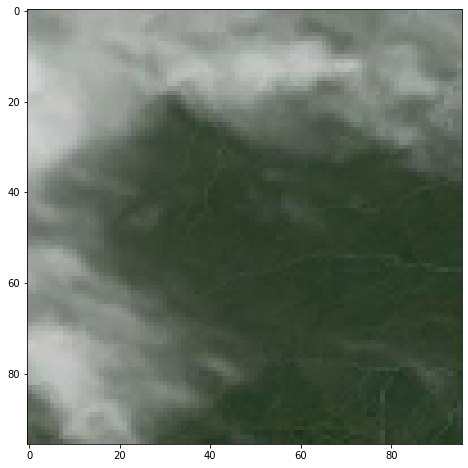

In [13]:
    mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype,No_Overlap=True)

make_example(train_loader=train_loader, classes=classes)

In [14]:
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate, 
                                                                learning_rate1=MAML_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs=np.load(dir+mtype+'_val_accs.npy')
    epoch_tracker=np.load(dir+'epoch_tracker.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.148
Validation Accuracy:  28.551136016845703
Validation Top3 Accuracy:  48.15340805053711
Epoch 20 - loss: 0.140
Validation Accuracy:  36.789772033691406
Validation Top3 Accuracy:  63.6363639831543
Epoch 30 - loss: 0.134
Validation Accuracy:  32.67045593261719
Validation Top3 Accuracy:  59.375
Epoch 40 - loss: 0.130
Validation Accuracy:  42.47159194946289
Validation Top3 Accuracy:  71.0227279663086
Epoch 50 - loss: 0.125
Validation Accuracy:  46.022727966308594
Validation Top3 Accuracy:  72.44318389892578
Epoch 60 - loss: 0.122
Validation Accuracy:  52.272727966308594
Validation Top3 Accuracy:  77.4147720336914
Epoch 70 - loss: 0.120
Validation Accuracy:  53.5511360168457
Validation Top3 Accuracy:  77.55681610107422
Epoch 80 - loss: 0.118
Validation Accuracy:  55.96590805053711
Validation Top3 Accuracy:  79.54545593261719
Epoch 90 - loss: 0.114
Validation Accuracy:  55.539772033691406
Validation Top3 Accuracy:  79.97158813476562
Epoch 100 - loss: 0.113
Validation Acc

In [15]:
acc,topk=make_test(model=model, testloader=test_loader)

Test Accuracy:  60.262939453125
Test Top3 Accuracy:  84.18915557861328


# MAML* first order approximation with support for n task batch and inner l2 regularization to compensate for approximation

Require: $p(\mathcal{T}):$ distribution over tasks 

Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$

3: $\quad$ Sample batch of tasks $\mathcal{T}_{i} \sim p(\mathcal{T})$

4: $\quad$ for all $\mathcal{T}_{i}$ do 

5: $\quad$ $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right)$ with respect to $K$ examples 

6: $\quad$ $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right) + ||\theta||_2$

7: $\quad$ end for

8: $\quad$Update $\theta \leftarrow \theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}})\right)$

9: end while




tensor(12) meadow


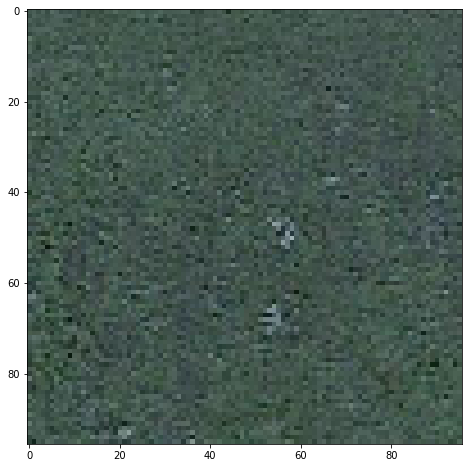

In [16]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype,No_Overlap=True)

make_example(train_loader=train_loader, classes=classes)
mtype='MAML2'

In [17]:
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs=n_epochs, 
                                                                learning_rate=0.00045, 
                                                                learning_rate1=0.0001/8, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')

MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.093
Validation Accuracy:  39.772727966308594
Validation Top3 Accuracy:  64.48863983154297
Epoch 20 - loss: 0.089
Validation Accuracy:  39.772727966308594
Validation Top3 Accuracy:  67.8977279663086
Epoch 30 - loss: 0.080
Validation Accuracy:  43.89204406738281
Validation Top3 Accuracy:  70.3125
Epoch 40 - loss: 0.088
Validation Accuracy:  49.71590805053711
Validation Top3 Accuracy:  73.57954406738281
Epoch 50 - loss: 0.083
Validation Accuracy:  51.27840805053711
Validation Top3 Accuracy:  76.98863983154297
Epoch 60 - loss: 0.078
Validation Accuracy:  54.6875
Validation Top3 Accuracy:  79.11931610107422
Epoch 70 - loss: 0.073
Validation Accuracy:  56.818180084228516
Validation Top3 Accuracy:  81.10795593261719
Epoch 80 - loss: 0.080
Validation Accuracy:  58.664772033691406
Validation Top3 Accuracy:  80.68181610107422
Epoch 90 - loss: 0.063
Validation Accuracy:  58.806819915771484
Validation Top3 Accuracy:  83.38068389892578
Epoch 100 - loss: 0.073
Validation Accuracy:

In [18]:
acc,topk=make_test(model=model, testloader=test_loader)


Test Accuracy:  63.986785888671875
Test Top3 Accuracy:  85.2835922241211


## MAML 32 way 1 shot 

In [19]:
# Params= Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
#                   'innerStep': 0.00005, 'MetaLR': 0.006, 'number_of_tasks': 32,
#                   'Order': False, 'outerVSinner': 1, 'epoch': n_epochs, 'aug': True,
#                    'num_classes': 45}
# if No_Overlap:
#     Params['num_classes']=26
# model = get_meta_model(Params)
# train_loader, val_loader, test_loader, c_dim, classes, ytrain = get_data(dir=dir, mtype=mtype,nwaykshot=True)
# model.to(device)
# mtype = 'MAMLnk'

# if First_Train: modelnk, epoch_tracker, MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks, MAML_nk_trainacc = trainMAML(mtype,
#                                                                                               model,
#                                                                                               train_loader, 
#                                                                                               Params, 
#                                                                                               val_loader,print_stride1 = print_stride,
#                                                                                               nwaykshot=True,
#                                                                                               trainset=train_loader,
#                                                                                               train_labels=ytrain,
#                                                                                               )
# else: 
#     model = get_model(mtype)
#     MAML_nk_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
#     MAML_nk_val_topks=np.load(dir+mtype+'_val_topks.npy')
#     MAML_nk_val_accs=np.load(dir+mtype+'_val_accs.npy')

In [20]:
# acc,topk=make_test(model=modelnk, testloader=test_loader)

## RESISC CNN with Augs

---

In [21]:
mtype='CNN_Aug'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype,No_Overlap=True)

if First_Train: model, CNN_Aug_loss_tracker, CNN_Aug_val_topks, CNN_Aug_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_Aug_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_Aug_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_Aug_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.135
Validation Accuracy:  37.21590805053711
Validation Top3 Accuracy:  66.05113983154297
Epoch 20 - loss: 0.119
Validation Accuracy:  46.73295593261719
Validation Top3 Accuracy:  73.72158813476562
Epoch 30 - loss: 0.127
Validation Accuracy:  52.556819915771484
Validation Top3 Accuracy:  77.84091186523438
Epoch 40 - loss: 0.118
Validation Accuracy:  53.835227966308594
Validation Top3 Accuracy:  79.40341186523438
Epoch 50 - loss: 0.117
Validation Accuracy:  61.07954406738281
Validation Top3 Accuracy:  83.38068389892578
Epoch 60 - loss: 0.105
Validation Accuracy:  62.64204406738281
Validation Top3 Accuracy:  84.375
Epoch 70 - loss: 0.102
Validation Accuracy:  65.48295593261719
Validation Top3 Accuracy:  84.51704406738281
Epoch 80 - loss: 0.110
Validation Accuracy:  63.210227966308594
Validation Top3 Accuracy:  87.5
Epoch 90 - loss: 0.093
Validation Accuracy:  68.18181610107422
Validation Top3 Accuracy:  85.51136016845703
Epoch 100 - loss: 0.104
Validation Accuracy:  66.

In [22]:
acc,topk = make_test(model=model, testloader=test_loader,get_worse=True)

Test Accuracy:  70.59752655029297
Test Top3 Accuracy:  89.49862670898438
2 = Best Task ID 
71 = Worst Task ID 


## RESISC CNN no Augs

---

In [23]:
mtype='CNN'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype,No_Overlap=True)

if First_Train: model, CNN_loss_tracker, CNN_val_topks, CNN_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,
                                                                augs=False,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.000
Validation Accuracy:  37.35795593261719
Validation Top3 Accuracy:  58.380680084228516
Epoch 20 - loss: 0.000
Validation Accuracy:  39.0625
Validation Top3 Accuracy:  58.522727966308594
Epoch 30 - loss: 0.000
Validation Accuracy:  38.6363639831543
Validation Top3 Accuracy:  59.09090805053711
Epoch 40 - loss: 0.000
Validation Accuracy:  39.772727966308594
Validation Top3 Accuracy:  58.664772033691406
Epoch 50 - loss: 0.000
Validation Accuracy:  38.494319915771484
Validation Top3 Accuracy:  57.67045593261719
Epoch 60 - loss: 0.000
Validation Accuracy:  39.20454406738281
Validation Top3 Accuracy:  58.380680084228516
Epoch 70 - loss: 0.000
Validation Accuracy:  38.77840805053711
Validation Top3 Accuracy:  58.522727966308594
Epoch 80 - loss: 0.000
Validation Accuracy:  39.772727966308594
Validation Top3 Accuracy:  58.664772033691406
Epoch 90 - loss: 0.000
Validation Accuracy:  37.9261360168457
Validation Top3 Accuracy:  57.244319915771484
Epoch 100 - loss: 0.000
Valida

In [24]:
acc,topk = make_test(model=model, testloader=test_loader,get_worse=True)

Test Accuracy:  34.69780349731445
Test Top3 Accuracy:  55.43269348144531
34 = Best Task ID 
1 = Worst Task ID 


## RESISC CHARTS

---

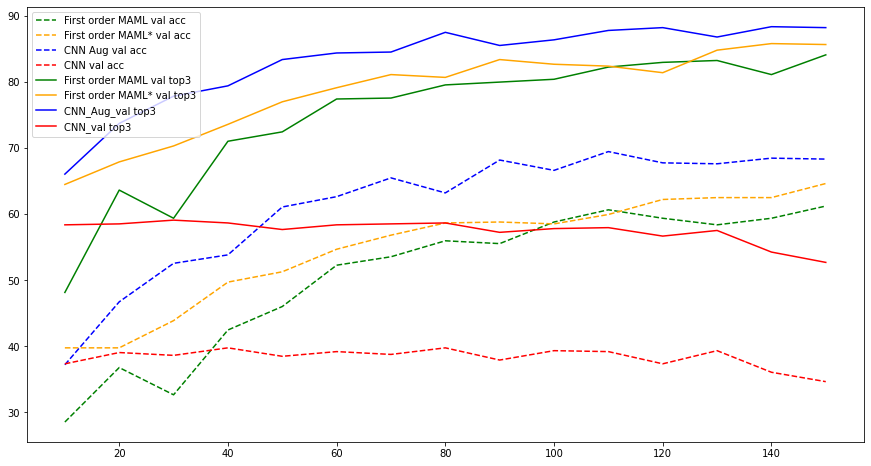

In [25]:
 make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2)#MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks
# )

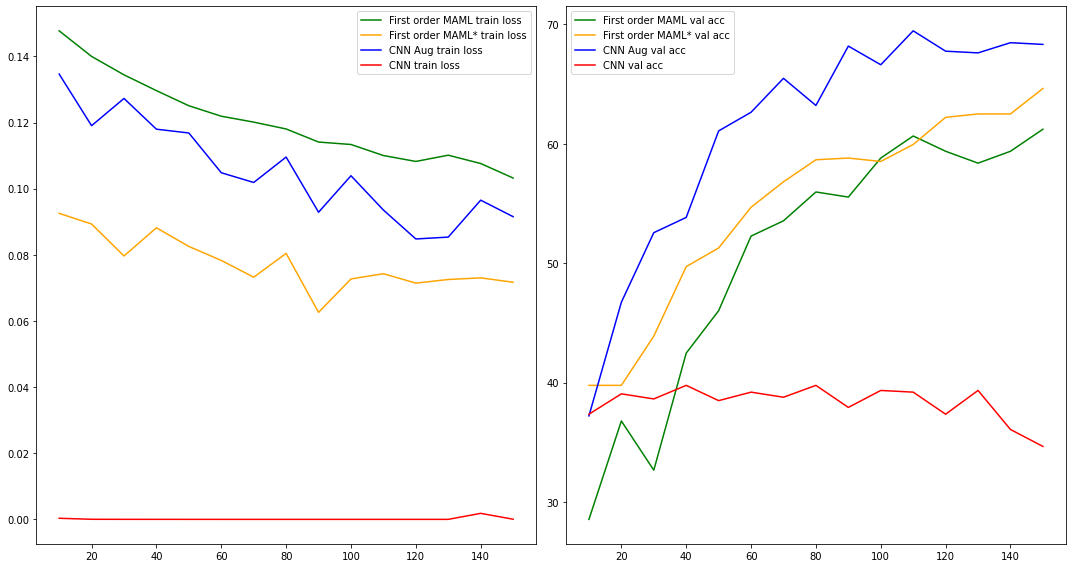

In [26]:
make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2)

## UC MERCED

---

In [27]:
UC_MAML_learning_rate = 0.0006
UC_CNN_learning_rate = 0.0006
UC_epochs = 3
UC_batch_size = 32

UC_data = np.load(dir+'UCMerced_images96.npy')
UC_labels = np.load(dir+'UCMerced_classes.npy')
UC_classes = np.load(dir+'UCMerced_class_names.npy')

UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

UCtrainset = make_dataset(UC_train_data, UC_train_labels)
UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

UCtestset = make_dataset(UC_test_data, UC_test_labels)
UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)

def UC_get_data():
    UC_data = np.load(dir+'UCMerced_images96.npy')
    UC_labels = np.load(dir+'UCMerced_classes.npy')
    UC_classes = np.load(dir+'UCMerced_class_names.npy')

    UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

    UCtrainset = make_dataset(UC_train_data, UC_train_labels)
    UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

    UCtestset = make_dataset(UC_test_data, UC_test_labels)
    UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)
    return UCtrain_loader, UCtest_loader

In [28]:
def UC_train(model1, trainloader, epochs=3, lr=0.0006):
    loss_tracker, epoch_tracker,acc_tracker = [], [], []
    #model.load('UC')
    model = copy.deepcopy(model1).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    for epoch in range(1, epochs+1):
        losses = 0
        accs = []
        acc = 0

        for X, y in trainloader:
            y_ = y 
            y = one_hot_embedding(y.to(device), len(UC_classes)).float()
            X = X.float().to(device)
            for param in model.parameters(): param.grad = None
            yhat = model(X)
            pred_loss = bce_loss(yhat, y)
            pred_loss.backward()
            optimizer.step()
            losses += pred_loss.item()
           
        for x, y in trainloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)
            
            yhat_max = torch.max(yhat, dim = 1)[1]
            correct = torch.sum(yhat_max == y)
            size = x.shape[0]            
            accs.append(100*(correct/size).data.item())
        print('UC Epoch ',epoch,"Train Accuracy: ",torch.mean(torch.FloatTensor(accs)).data.item())
        acc_tracker.append(torch.mean(torch.FloatTensor(accs)).data.item())
        epoch_tracker.append(epoch)
        loss_tracker.append(losses)
    return model, epoch_tracker, loss_tracker,acc_tracker
def avg_UC_test(mtype,runs,model=None):
    model1 = get_model(mtype=mtype,load=True)
    if mtype=='MAMLnk':
        model1 = model
    test_acc,test_topk = [], [] 
    for _ in range(runs):
        model2= copy.deepcopy(model1.to('cpu')).to(device)
        UC_MAML_learning_rate = 0.0006
        UC_CNN_learning_rate = 0.0006
        UC_epochs = 3
        UC_batch_size = 32
        UCtrain_loader,UCtest_loader = UC_get_data()
        model2.fce = nn.Linear(1024, 21)
        model2 = model2.to(device)
        model2, epoch_tracker, CNN_Aug_loss_tracker,CNN_AUG_acc_tracker = UC_train(model1=model2, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc,topk =make_test(model=model2, testloader=UCtest_loader,get_worse=False)
        test_acc.append(acc)
        test_topk.append(topk)
    print(mtype + 'Accuracy on UC as an avg of ',runs,": ",np.mean(test_acc))
    print(mtype + 'TopK on UC as an avg of ',runs,": ",np.mean(test_topk))

In [29]:
mtype='MAML'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker, MAML_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.16964340209961
UC Epoch  2 Train Accuracy:  72.32142639160156
UC Epoch  3 Train Accuracy:  82.36607360839844


In [30]:
acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAML',20)


Test Accuracy:  65.98558044433594
Test Top3 Accuracy:  85.69711303710938
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  62.27678680419922
UC Epoch  2 Train Accuracy:  79.91071319580078
UC Epoch  3 Train Accuracy:  88.39286041259766
Test Accuracy:  64.54326629638672
Test Top3 Accuracy:  85.15625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  60.9375
UC Epoch  2 Train Accuracy:  77.90178680419922
UC Epoch  3 Train Accuracy:  88.39286041259766
Test Accuracy:  61.89904022216797
Test Top3 Accuracy:  83.29326629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  54.46428680419922
UC Epoch  2 Train Accuracy:  72.99107360839844
UC Epoch  3 Train Accuracy:  85.26786041259766
Test Accuracy:  58.293270111083984
Test Top3 Accuracy:  84.49519348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  60.26785659790039
UC Epoch  2 Train Accuracy:  74.33036041259766
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  63.28125
Test Top3 Accuracy:  85.87740325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.83928680419922
UC Epoch  2 Train Accuracy:  75.44642639160156
UC Epoch  3 Train Accuracy:  86.16071319580078
Test Accuracy:  59.97595977783203
Test Top3 Accuracy:  82.99279022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  58.03571319580078
UC Epoch  2 Train Accuracy:  77.45536041259766
UC Epoch  3 Train Accuracy:  85.49107360839844
Test Accuracy:  63.16105651855469
Test Top3 Accuracy:  85.27644348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  58.25893020629883
UC Epoch  2 Train Accuracy:  79.46428680419922
UC Epoch  3 Train Accuracy:  84.82142639160156
Test Accuracy:  59.375
Test Top3 Accuracy:  83.77404022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.39285659790039
UC Epoch  2 Train Accuracy:  77.67857360839844
UC Epoch  3 Train Accuracy:  85.26786041259766
Test Accuracy:  62.5
Test Top3 Accuracy:  86.41826629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  60.49106979370117
UC Epoch  2 Train Accuracy:  76.5625
UC Epoch  3 Train Accuracy:  88.16963958740234
Test Accuracy:  63.40144348144531
Test Top3 Accuracy:  86.41826629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  54.24106979370117
UC Epoch  2 Train Accuracy:  79.01786041259766
UC Epoch  3 Train Accuracy:  86.16071319580078
Test Accuracy:  63.04086685180664
Test Top3 Accuracy:  84.61538696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.625
UC Epoch  2 Train Accuracy:  74.33036041259766
UC Epoch  3 Train Accuracy:  88.16963958740234
Test Accuracy:  63.82211685180664
Test Top3 Accuracy:  85.33654022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  59.375
UC Epoch  2 Train Accuracy:  80.13392639160156
UC Epoch  3 Train Accuracy:  83.92857360839844
Test Accuracy:  61.418270111083984
Test Top3 Accuracy:  84.19470977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  62.27678680419922
UC Epoch  2 Train Accuracy:  79.24107360839844
UC Epoch  3 Train Accuracy:  87.27678680419922
Test Accuracy:  63.94230651855469
Test Top3 Accuracy:  85.99759674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  55.35714340209961
UC Epoch  2 Train Accuracy:  81.69642639160156
UC Epoch  3 Train Accuracy:  89.73213958740234
Test Accuracy:  63.88220977783203
Test Top3 Accuracy:  85.21634674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  60.71428680419922
UC Epoch  2 Train Accuracy:  71.42857360839844
UC Epoch  3 Train Accuracy:  82.58928680419922
Test Accuracy:  61.658653259277344
Test Top3 Accuracy:  84.19470977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  61.16071319580078
UC Epoch  2 Train Accuracy:  81.25
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  62.92067337036133
Test Top3 Accuracy:  85.27644348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  54.46428680419922
UC Epoch  2 Train Accuracy:  71.42857360839844
UC Epoch  3 Train Accuracy:  87.5
Test Accuracy:  60.75720977783203
Test Top3 Accuracy:  84.73558044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  58.92856979370117
UC Epoch  2 Train Accuracy:  77.23213958740234
UC Epoch  3 Train Accuracy:  88.39286041259766
Test Accuracy:  60.096153259277344
Test Top3 Accuracy:  86.53845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  59.59821319580078
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  83.48213958740234
Test Accuracy:  63.10095977783203
Test Top3 Accuracy:  86.17788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  60.71428680419922
UC Epoch  2 Train Accuracy:  73.21428680419922
UC Epoch  3 Train Accuracy:  86.38392639160156
Test Accuracy:  62.800479888916016
Test Top3 Accuracy:  85.99759674072266
MAMLAccuracy on UC as an avg of  20 :  62.19350929260254
MAMLTopK on UC as an avg of  20 :  85.09915885925292


In [31]:
mtype='MAML2'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker2,MAML2_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.625
UC Epoch  2 Train Accuracy:  84.82142639160156
UC Epoch  3 Train Accuracy:  89.0625


In [32]:
acc,topk =make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAML2',20)

Test Accuracy:  64.90384674072266
Test Top3 Accuracy:  86.35816955566406
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.95536041259766
UC Epoch  2 Train Accuracy:  79.6875
UC Epoch  3 Train Accuracy:  90.84821319580078
Test Accuracy:  63.64182662963867
Test Top3 Accuracy:  86.83894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  61.16071319580078
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  95.3125
Test Accuracy:  64.30288696289062
Test Top3 Accuracy:  86.53845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.61606979370117
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  89.95536041259766
Test Accuracy:  64.48316955566406
Test Top3 Accuracy:  86.23798370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.39285659790039
UC Epoch  2 Train Accuracy:  88.61607360839844
UC Epoch  3 Train Accuracy:  90.84821319580078
Test Accuracy:  68.99038696289062
Test Top3 Accuracy:  86.95913696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.75892639160156
UC Epoch  2 Train Accuracy:  81.69642639160156
UC Epoch  3 Train Accuracy:  91.96428680419922
Test Accuracy:  62.800479888916016
Test Top3 Accuracy:  86.11779022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.51786041259766
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  94.41963958740234
Test Accuracy:  65.08413696289062
Test Top3 Accuracy:  85.33654022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.16964340209961
UC Epoch  2 Train Accuracy:  84.82142639160156
UC Epoch  3 Train Accuracy:  93.97321319580078
Test Accuracy:  65.92548370361328
Test Top3 Accuracy:  87.31970977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.74107360839844
UC Epoch  2 Train Accuracy:  83.48213958740234
UC Epoch  3 Train Accuracy:  89.95536041259766
Test Accuracy:  66.04566955566406
Test Top3 Accuracy:  87.74038696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.07142639160156
UC Epoch  2 Train Accuracy:  87.72321319580078
UC Epoch  3 Train Accuracy:  89.50892639160156
Test Accuracy:  63.88220977783203
Test Top3 Accuracy:  85.45673370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.96428680419922
UC Epoch  2 Train Accuracy:  81.69642639160156
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  63.82211685180664
Test Top3 Accuracy:  86.71875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.73213958740234
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  93.30357360839844
Test Accuracy:  64.60336303710938
Test Top3 Accuracy:  86.83894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.64286041259766
UC Epoch  2 Train Accuracy:  85.26786041259766
UC Epoch  3 Train Accuracy:  95.53571319580078
Test Accuracy:  67.06730651855469
Test Top3 Accuracy:  87.01923370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.29463958740234
UC Epoch  2 Train Accuracy:  85.49107360839844
UC Epoch  3 Train Accuracy:  92.1875
Test Accuracy:  63.64182662963867
Test Top3 Accuracy:  87.74038696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.97321319580078
UC Epoch  2 Train Accuracy:  84.59821319580078
UC Epoch  3 Train Accuracy:  95.75892639160156
Test Accuracy:  64.24279022216797
Test Top3 Accuracy:  85.81730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  60.9375
UC Epoch  2 Train Accuracy:  83.70536041259766
UC Epoch  3 Train Accuracy:  93.30357360839844
Test Accuracy:  64.42308044433594
Test Top3 Accuracy:  87.68029022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.96428680419922
UC Epoch  2 Train Accuracy:  87.05357360839844
UC Epoch  3 Train Accuracy:  96.42857360839844
Test Accuracy:  63.581729888916016
Test Top3 Accuracy:  85.51683044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.53571319580078
UC Epoch  2 Train Accuracy:  80.80357360839844
UC Epoch  3 Train Accuracy:  89.28571319580078
Test Accuracy:  62.07932662963867
Test Top3 Accuracy:  85.69711303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  61.83035659790039
UC Epoch  2 Train Accuracy:  83.03571319580078
UC Epoch  3 Train Accuracy:  91.29463958740234
Test Accuracy:  64.36298370361328
Test Top3 Accuracy:  86.29808044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.40178680419922
UC Epoch  2 Train Accuracy:  81.91963958740234
UC Epoch  3 Train Accuracy:  89.95536041259766
Test Accuracy:  65.86538696289062
Test Top3 Accuracy:  87.86058044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.83928680419922
UC Epoch  2 Train Accuracy:  80.13392639160156
UC Epoch  3 Train Accuracy:  90.84821319580078
Test Accuracy:  61.83894348144531
Test Top3 Accuracy:  86.17788696289062
MAML2Accuracy on UC as an avg of  20 :  64.53425521850586
MAML2TopK on UC as an avg of  20 :  86.59555435180664


In [33]:
# mtype='MAMLnk'
# model = modelnk

# if Freeze:
#     # for param in model.parameters():
#         param.requires_grad = False

# model.fce = nn.Linear(1024, 21)
# model = model.to(device)

# modelnk, epoch_tracker, MAMLnk_loss_tracker, MAMLnk_acc_tracker = UC_train(model1=modelnk, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

In [34]:
# acc,topk =make_test(model=modelnk, testloader=UCtest_loader,get_worse=False)
# avg_UC_test('MAMLnk',20,model=modelnk)

In [35]:
mtype='CNN'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_loss_tracker,CNN_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.01786041259766
UC Epoch  2 Train Accuracy:  93.75
UC Epoch  3 Train Accuracy:  96.875


In [36]:
acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('CNN',20)

Test Accuracy:  43.87019348144531
Test Top3 Accuracy:  67.72836303710938
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.90178680419922
UC Epoch  2 Train Accuracy:  95.75892639160156
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  47.355770111083984
Test Top3 Accuracy:  68.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.90178680419922
UC Epoch  2 Train Accuracy:  98.66071319580078
UC Epoch  3 Train Accuracy:  98.21428680419922
Test Accuracy:  46.153846740722656
Test Top3 Accuracy:  70.61298370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.02678680419922
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  47.596153259277344
Test Top3 Accuracy:  68.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.55357360839844
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  46.814903259277344
Test Top3 Accuracy:  69.05048370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.24107360839844
UC Epoch  2 Train Accuracy:  96.875
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  45.73317337036133
Test Top3 Accuracy:  70.49279022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.44642639160156
UC Epoch  2 Train Accuracy:  93.97321319580078
UC Epoch  3 Train Accuracy:  98.21428680419922
Test Accuracy:  42.72836685180664
Test Top3 Accuracy:  69.17066955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.33928680419922
UC Epoch  2 Train Accuracy:  94.64286041259766
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  41.64663314819336
Test Top3 Accuracy:  66.70673370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.66071319580078
UC Epoch  2 Train Accuracy:  92.85713958740234
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  43.449520111083984
Test Top3 Accuracy:  68.93029022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.91071319580078
UC Epoch  2 Train Accuracy:  96.42857360839844
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  46.09375
Test Top3 Accuracy:  69.77163696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.66071319580078
UC Epoch  2 Train Accuracy:  95.53571319580078
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  42.96875
Test Top3 Accuracy:  67.06730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.09821319580078
UC Epoch  2 Train Accuracy:  96.875
UC Epoch  3 Train Accuracy:  98.21428680419922
Test Accuracy:  42.42788314819336
Test Top3 Accuracy:  68.44951629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.0
UC Epoch  2 Train Accuracy:  95.98213958740234
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  45.252403259277344
Test Top3 Accuracy:  71.57451629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.67857360839844
UC Epoch  2 Train Accuracy:  94.64286041259766
UC Epoch  3 Train Accuracy:  97.76786041259766
Test Accuracy:  43.50961685180664
Test Top3 Accuracy:  70.91345977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.6875
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  97.54463958740234
Test Accuracy:  44.831729888916016
Test Top3 Accuracy:  68.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.00892639160156
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  46.69470977783203
Test Top3 Accuracy:  70.91345977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.22321319580078
UC Epoch  2 Train Accuracy:  98.21428680419922
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  44.050479888916016
Test Top3 Accuracy:  70.43269348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.45536041259766
UC Epoch  2 Train Accuracy:  96.20536041259766
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  46.75480651855469
Test Top3 Accuracy:  70.07211303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.33036041259766
UC Epoch  2 Train Accuracy:  94.86607360839844
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  45.19230651855469
Test Top3 Accuracy:  69.05048370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.24107360839844
UC Epoch  2 Train Accuracy:  95.3125
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  45.19230651855469
Test Top3 Accuracy:  68.99038696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.65178680419922
UC Epoch  2 Train Accuracy:  91.74107360839844
UC Epoch  3 Train Accuracy:  98.21428680419922
Test Accuracy:  46.45432662963867
Test Top3 Accuracy:  68.62980651855469
CNNAccuracy on UC as an avg of  20 :  45.04507179260254
CNNTopK on UC as an avg of  20 :  69.3539665222168


In [37]:
mtype='CNN_Aug'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_Aug_loss_tracker,CNN_AUG_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.08928680419922
UC Epoch  2 Train Accuracy:  80.35713958740234
UC Epoch  3 Train Accuracy:  91.96428680419922


In [38]:
acc,topk=make_test(model=model, testloader=UCtest_loader,get_worse=False)

Test Accuracy:  69.77163696289062
Test Top3 Accuracy:  89.96394348144531


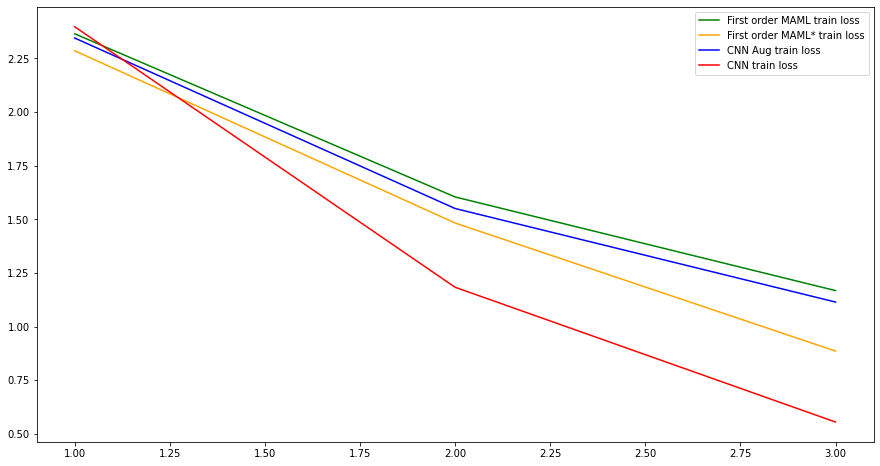

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  56.91964340209961
UC Epoch  2 Train Accuracy:  77.00892639160156
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  68.81009674072266
Test Top3 Accuracy:  89.96394348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  62.94643020629883
UC Epoch  2 Train Accuracy:  78.34821319580078
UC Epoch  3 Train Accuracy:  89.73213958740234
Test Accuracy:  65.44470977783203
Test Top3 Accuracy:  88.10095977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.41071319580078
UC Epoch  2 Train Accuracy:  83.03571319580078
UC Epoch  3 Train Accuracy:  87.27678680419922
Test Accuracy:  68.75
Test Top3 Accuracy:  89.54326629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.39285659790039
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  92.85713958740234
Test Accuracy:  67.24759674072266
Test Top3 Accuracy:  86.83894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.83928680419922
UC Epoch  2 Train Accuracy:  84.82142639160156
UC Epoch  3 Train Accuracy:  92.1875
Test Accuracy:  66.34615325927734
Test Top3 Accuracy:  87.43990325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.83928680419922
UC Epoch  2 Train Accuracy:  83.70536041259766
UC Epoch  3 Train Accuracy:  89.95536041259766
Test Accuracy:  68.38941955566406
Test Top3 Accuracy:  89.30288696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.84821319580078
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  93.30357360839844
Test Accuracy:  67.24759674072266
Test Top3 Accuracy:  87.86058044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.63392639160156
UC Epoch  2 Train Accuracy:  79.6875
UC Epoch  3 Train Accuracy:  87.27678680419922
Test Accuracy:  68.87019348144531
Test Top3 Accuracy:  87.92066955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  63.39285659790039
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  89.28571319580078
Test Accuracy:  67.42788696289062
Test Top3 Accuracy:  88.94230651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  62.27678680419922
UC Epoch  2 Train Accuracy:  81.69642639160156
UC Epoch  3 Train Accuracy:  87.72321319580078
Test Accuracy:  65.80529022216797
Test Top3 Accuracy:  88.64183044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.50892639160156
UC Epoch  2 Train Accuracy:  79.46428680419922
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  65.20433044433594
Test Top3 Accuracy:  85.81730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.74107360839844
UC Epoch  2 Train Accuracy:  82.14286041259766
UC Epoch  3 Train Accuracy:  85.9375
Test Accuracy:  67.72836303710938
Test Top3 Accuracy:  89.66345977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.41071319580078
UC Epoch  2 Train Accuracy:  79.6875
UC Epoch  3 Train Accuracy:  89.50892639160156
Test Accuracy:  65.625
Test Top3 Accuracy:  88.94230651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.28571319580078
UC Epoch  2 Train Accuracy:  81.47321319580078
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  68.81009674072266
Test Top3 Accuracy:  88.46154022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.52678680419922
UC Epoch  2 Train Accuracy:  83.48213958740234
UC Epoch  3 Train Accuracy:  89.50892639160156
Test Accuracy:  64.78365325927734
Test Top3 Accuracy:  87.43990325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.51786041259766
UC Epoch  2 Train Accuracy:  85.71428680419922
UC Epoch  3 Train Accuracy:  89.95536041259766
Test Accuracy:  65.86538696289062
Test Top3 Accuracy:  87.92066955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.96428680419922
UC Epoch  2 Train Accuracy:  82.58928680419922
UC Epoch  3 Train Accuracy:  88.16963958740234
Test Accuracy:  67.60816955566406
Test Top3 Accuracy:  89.0625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.08036041259766
UC Epoch  2 Train Accuracy:  81.02678680419922
UC Epoch  3 Train Accuracy:  86.60713958740234
Test Accuracy:  66.70673370361328
Test Top3 Accuracy:  88.76201629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.40178680419922
UC Epoch  2 Train Accuracy:  78.34821319580078
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  68.99038696289062
Test Top3 Accuracy:  89.00240325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.50892639160156
UC Epoch  2 Train Accuracy:  77.67857360839844
UC Epoch  3 Train Accuracy:  86.83036041259766
Test Accuracy:  66.70673370361328
Test Top3 Accuracy:  87.07933044433594
CNN_AugAccuracy on UC as an avg of  20 :  67.11838989257812
CNN_AugTopK on UC as an avg of  20 :  88.33533630371093


In [39]:
basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2)
avg_UC_test('CNN_Aug',20)

## Thoughts on UC


It is incrediably easy to overfit to UC mercer if we train each optimization scheme from sctrach as shown below. Since We know afte training on RESIC and then trasnfer learning on UC, we can say the model training on RESIC learned important features of the schenes that would otherwise not have been learned if it was just UC. Now when comparing optimization schemes, we can examine the testing accuracy of UC after training on RESIC and say which model's weights were primed for fast learning and fast adaption.


In [40]:
def fresh_train_UC(mtype,load):
    model = get_model(mtype=mtype,load=load)
    UC_MAML_learning_rate = 0.0006
    UC_CNN_learning_rate = 0.0006
    UC_epochs = 3
    UC_batch_size = 32
    UCtrain_loader,UCtest_loader = UC_get_data()
    model.fce = nn.Linear(1024, 21)
    model = model.to(device)
    #model.save('UC'+mtype)
    if mtype == 'CNN':
        print(mtype)
        model, epoch_tracker, CNN_Aug_loss_tracker,acc = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
    elif mtype == "MAML":
        print(mtype)
        model, _, _, _, _=  train(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype, augs=True)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

    elif mtype == 'MAML2':
        print(mtype)
        model, _, _, _, _, =  train2(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
        return acc
    elif mtype == 'MAMLnk':
        print(mtype)
        Params= Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': UC_MAML_learning_rate, 'MetaLR': UC_MAML_learning_rate, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': UC_epochs, 'aug': True,
                   'num_classes': 45}
        model,_,_,_,_,_ =trainMAML(mtype,model,UCtrain_loader,Params,val_loader,print_stride,nwaykshot=False)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

CNN_acc = fresh_train_UC('CNN',load=False)
MAML_acc = fresh_train_UC('MAML',load=False)
MAML2_acc = fresh_train_UC('MAML2',load=False)
# MAMLnk_acc = fresh_train_UC('MAMLnk',load=False) dont run this get "CUDA error: device-side assert triggered" error, I think above calls demonstrate it enough how easy it is to overfit to the data with the best 3 models


    

CNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.90178680419922
UC Epoch  2 Train Accuracy:  95.53571319580078
UC Epoch  3 Train Accuracy:  98.66071319580078
Test Accuracy:  30.528846740722656
Test Top3 Accuracy:  53.78605651855469
MAML


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saving...
Test Accuracy:  6.490384578704834
Test Top3 Accuracy:  17.668270111083984
MAML2
MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saving...
Test Accuracy:  9.014423370361328
Test Top3 Accuracy:  14.543269157409668


# MAML second order on traditonal dataloader, tuned to best performance by hand 

In [41]:
mtype='MAML'

Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': .00005*5/24, 'MetaLR': .006*5/48, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': n_epochs, 'aug': True,
                   'num_classes': 45}
model = get_meta_model(Params,load=False)

train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
mtype='MAMLnk'
model.to(device)
if First_Train: modelnk, epoch_tracker, MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks, MAML_nk_train_acc = trainMAML(mtype,
                                                                                              model,
                                                                                              train_loader,
                                                                                              Params,
                                                                                              val_loader, 
                                                                                               print_stride1=print_stride
                                                                                              )
else: 
    model = get_model(mtype)
    MAML_nk_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_nk_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_nk_val_accs=np.load(dir+mtype+'_val_accs.npy')
acc,topk=make_test(model=modelnk, testloader=test_loader)
avg_UC_test('MAMLnk',20,model=modelnk)

RuntimeError: ignored

first order maml with 16 task inner loop l2 reg on n way k shot data, best learning rates normalized by batch size 

In [ ]:
mtype='MAML2'
Params['nways']=5
Params['number_of_tasks']=32
train_loader, val_loader, test_loader, c_dim, classes, ytrain = get_data(dir=dir, mtype=mtype,nwaykshot=True)
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs, 
                                                                                                    .00045*Params['nways']/batch_size, 
                                                                                                    .0001/8*Params['nways']/batch_size,
                                                                                                    train_loader, 
                                                                                                    val_loader, 
                                                                                                    c_dim, mtype,
                                                                                                    print_stride1 = print_stride,
                                                                                                    trainset= train_loader, 
                                                                                                    nwaykshot=True , 
                                                                                                    train_labels = ytrain,
                                                                                                    Params=Params)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')
avg_UC_test(mtype,20)

## Scrap Work Area 

---

In [ ]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''

In [ ]:
# def trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2):
#     train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
#     make_example(train_loader=train_loader, classes=classes)
#     if mtype=='CNN' or mtype == "MAML":
#         model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train(n_epochs=n_epochs, 
#                                                                     learning_rate=learning_rate_1, 
#                                                                     learning_rate1=learning_rate_2, 
#                                                                     train_loader=train_loader, 
#                                                                     val_loader=val_loader, 
#                                                                     c_dim=c_dim, 
#                                                                     mtype=mtype,print_stride1=1)
#     elif mtype == 'MAML2'
#          model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train2(n_epochs=n_epochs, 
#                                                                     learning_rate=learning_rate_1, 
#                                                                     learning_rate1=learning_rate_2, 
#                                                                     train_loader=train_loader, 
#                                                                     val_loader=val_loader, 
#                                                                     c_dim=c_dim, 
#                                                                     mtype=mtype,print_stride1=1)
#     return model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker

# def AVG_n_model(dir,mtype,n_epochs,learning_rate_1,learning_rate_2,runs=5,UC_or_RES):
#     list_loss_tracker,list_val_topk_tracker,list_val_acc_tracker,testacc,testtopk = [],[],[],[],[]
#     for _ in range(runs):
#         if UC_or_RES=='RES'
#             model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker = trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2)
#             list_loss_tracker.append(loss_tracker)
#             list_val_topk_tracker.append(val_topk_tracker)
#             list_val_acc_tracker.append(val_acc_tracker)

#             test_acc, test_topk  = make_test(model,test_loader)
#             testacc.append(test_acc)
#             testtopk.append(test_topk)
#         else:
#             testacc1 , testtopk1 = fresh_train_UC(mtype,load=True)
#             testacc.append(testacc1)
#             testtopk.append(testtopk1)


#     avg_loss = numpy.mean(numpy.array(list_loss_tracker), axis=0)
#     avg_valtopk = numpy.mean(numpy.array(list_val_topk_tracker), axis=0)
#     avg_valacc = numpy.mean(numpy.array(val_acc_tracker), axis=0)
    
#     test__valacc = numpy.mean(numpy.array(testacc), axis=0)
#     test___valacc = numpy.mean(numpy.array(testtopk), axis=0)

#     return avg_loss,avg_valtopk,avg_valacc,test__valacc,test___valacc





    
